In [1]:
# ========================
# 1. Import Dependencies
# ========================
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# ========================
# 2. Configuration Settings
# ========================
FRAME_SIZE = (160, 160)  # Reduced for faster training
SEQUENCE_LENGTH = 12     # Reduced for faster training
BATCH_SIZE = 2           # Reduced for lower memory
EPOCHS = 10
DATASET_PATH = r'C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF'


In [3]:
# ========================
# 3. Face Detection Utility
# ========================
def detect_and_crop_face(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = frame[y:y+h, x:x+w]
        return cv2.resize(face, FRAME_SIZE)
    return cv2.resize(frame, FRAME_SIZE)

In [4]:
# ========================
# 4. Frame Extraction
# ========================
def extract_frames(video_path, max_frames=SEQUENCE_LENGTH):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while len(frames) < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        face = detect_and_crop_face(frame)
        face = image.img_to_array(face) / 255.0
        frames.append(face)
    cap.release()
    while len(frames) < max_frames:
        frames.append(np.zeros_like(frames[0]))
    return np.array(frames)

In [5]:
# ========================
# 5. Feature Extractor - CNN (MobileNetV2)
# ========================
def build_feature_extractor():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*FRAME_SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    return Model(inputs=base_model.input, outputs=x)

In [6]:
# ========================
# 6. LSTM Classifier Model (Functional API)
# ========================
def build_deepfake_model(feature_extractor):
    video_input = Input(shape=(SEQUENCE_LENGTH, *FRAME_SIZE, 3))
    x = TimeDistributed(feature_extractor)(video_input)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# ========================
# 7. Load Video Paths and Labels
# ========================
def load_video_paths(dataset_path):
    video_paths, labels = [], []
    real_folders = ['Celeb-real', 'YouTube-real']
    fake_folders = ['Celeb-synthesis']

    # Label 0 = REAL
    for folder in real_folders:
        full_path = os.path.join(dataset_path, folder)
        for file in os.listdir(full_path):
            if file.endswith('.mp4'):
                video_paths.append(os.path.join(full_path, file))
                labels.append(0)

    # Label 1 = FAKE
    for folder in fake_folders:
        full_path = os.path.join(dataset_path, folder)
        for file in os.listdir(full_path):
            if file.endswith('.mp4'):
                video_paths.append(os.path.join(full_path, file))
                labels.append(1)

    return video_paths, labels


In [8]:
# ========================
# 8. Data Generator Class
# ========================
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.video_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for path, label in zip(batch_paths, batch_labels):
            frames = extract_frames(path)
            X.append(frames)
            y.append(label)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.video_paths, self.labels))
            np.random.shuffle(combined)
            self.video_paths, self.labels = zip(*combined)

In [9]:
# ========================
# 9. Load Data and Build Model
# ========================
print("Loading video dataset...")
video_paths, labels = load_video_paths(DATASET_PATH)
train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_gen = VideoDataGenerator(train_paths, train_labels)
test_gen = VideoDataGenerator(test_paths, test_labels, shuffle=False)

print("Initializing model...")
feature_extractor = build_feature_extractor()
model = build_deepfake_model(feature_extractor)
model.summary()

Loading video dataset...
Initializing model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 160, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 1280)            │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         344,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 2,572,417 (9.81 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
# ========================
# 10. Train Model
# ========================
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
cw_dict = {i: cw[i] for i in range(len(cw))}
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

print("Training the model...")
history = model.fit(train_gen, validation_data=test_gen, epochs=EPOCHS, class_weight=cw_dict, callbacks=[early_stop])


Training the model...
Epoch 1/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 2404s 4s/step - accuracy: 0.5849 - loss: 0.6880 - val_accuracy: 0.6971 - val_loss: 0.5969
Epoch 2/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1966s 4s/step - accuracy: 0.7012 - loss: 0.5869 - val_accuracy: 0.8257 - val_loss: 0.4636
Epoch 3/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1938s 4s/step - accuracy: 0.7220 - loss: 0.5656 - val_accuracy: 0.8423 - val_loss: 0.4116
Epoch 4/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1136s 2s/step - accuracy: 0.8190 - loss: 0.4774 - val_accuracy: 0.8589 - val_loss: 0.4089
Epoch 5/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.8179 - loss: 0.4275 - val_accuracy: 0.8714 - val_loss: 0.3901
Epoch 6/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.8174 - loss: 0.4408 - val_accuracy: 0.8963 - val_loss: 0.3026
Epoch 7/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.8848 - loss: 0.3125 - val_accuracy: 0.8880 - val_loss: 0.2730
Epoch 8/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - accuracy: 0.8923

In [11]:
# ========================
# 11. Save Model
# ========================
model.save("deepfake_detector_resnet.keras")
print("Model saved successfully.")

Model saved successfully.


In [12]:
# ========================
# 12. Evaluate Model
# ========================
y_true, y_pred = [], []
for X_batch, y_batch in test_gen:
    preds = (model.predict(X_batch) > 0.5).astype(int).flatten()
    y_true.extend(y_batch)
    y_pred.extend(preds)
    if len(y_true) >= len(test_labels):
        break

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

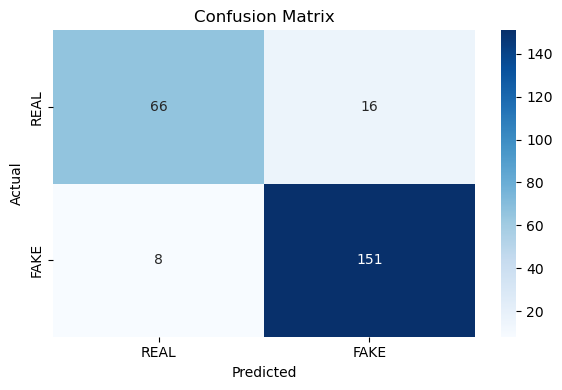

In [13]:
# ========================
# 13. Confusion Matrix Plot
# ========================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

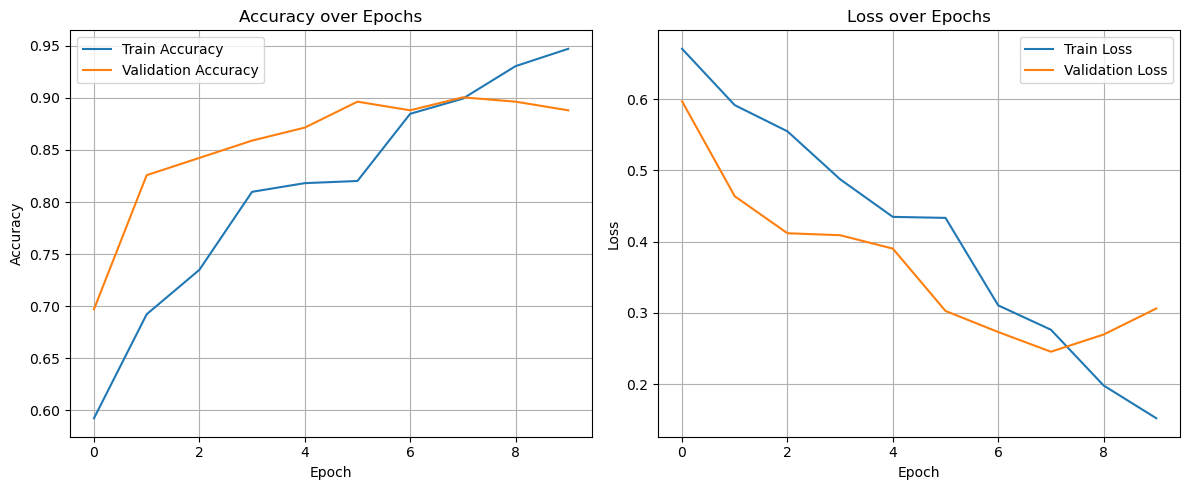

In [14]:
# ========================
# 14. Training Curves
# ========================
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

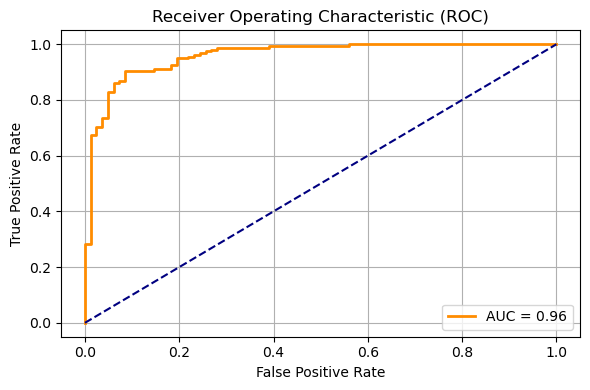

In [15]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
y_probs = []
for X_batch, _ in test_gen:
    probs = model.predict(X_batch).flatten()
    y_probs.extend(probs)
    if len(y_probs) >= len(test_labels):
        break

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

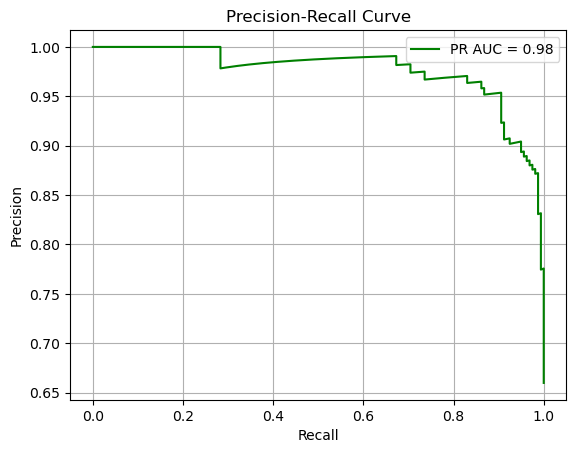

In [16]:
from sklearn.metrics import precision_recall_curve, auc

y_probs = []
for X_batch, _ in test_gen:
    probs = model.predict(X_batch).flatten()
    y_probs.extend(probs)
    if len(y_probs) >= len(test_labels):
        break

precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [17]:
from sklearn.metrics import recall_score, roc_auc_score

sensitivity = recall_score(y_true, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
youden_j = sensitivity + specificity - 1
print(f"Youden's J statistic: {youden_j:.2f}")


Youden's J statistic: 0.75


In [18]:
from sklearn.metrics import roc_auc_score
y_probs = model.predict(test_gen, verbose=0).flatten()
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.2f}")


AUC Score: 0.96


In [19]:
from sklearn.metrics import cohen_kappa_score
print(f"Cohen’s Kappa: {cohen_kappa_score(y_true, y_pred):.2f}")


Cohen’s Kappa: 0.77


In [20]:
# ========================
# 14. Predict Custom Video
# ========================
def predict_custom_video(video_path):
    custom_video = extract_frames(video_path, max_frames=SEQUENCE_LENGTH)
    custom_video = np.expand_dims(custom_video, axis=0)
    pred = model.predict(custom_video)[0][0]
    label = "REAL" if pred < 0.5 else "FAKE"
    confidence = (1 - pred if label == "REAL" else pred) * 100
    print(f"Prediction: {label} ({confidence:.2f}%)")

# Now call it like this AFTER defining it:
predict_custom_video(r"C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF\Celeb-synthesis\id0_id6_0007.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Prediction: FAKE (94.69%)


In [21]:
def predict_custom_video(video_path):
    custom_video = extract_frames(video_path, max_frames=SEQUENCE_LENGTH)
    custom_video = np.expand_dims(custom_video, axis=0)
    pred = model.predict(custom_video)[0][0]
    label = "REAL" if pred < 0.5 else "FAKE"
    confidence = (1 - pred if label == "REAL" else pred) * 100
    print(f"Prediction: {label} ({confidence:.2f}%)")

# Now call it like this AFTER defining it:
predict_custom_video(r"C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF\YouTube-real\00116.mp4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediction: REAL (99.28%)


In [52]:
def predict_custom_video(video_path):
    custom_video = extract_frames(video_path, max_frames=SEQUENCE_LENGTH)
    custom_video = np.expand_dims(custom_video, axis=0)
    pred = model.predict(custom_video)[0][0]
    label = "REAL" if pred < 0.5 else "FAKE"
    confidence = (1 - pred if label == "REAL" else pred) * 100
    print(f"Prediction: {label} ({confidence:.2f}%)")

# Now call it like this AFTER defining it:
predict_custom_video(r"C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF\Celeb-synthesis\id9_id17_0004.mp4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Prediction: FAKE (97.83%)


In [54]:
# MobileNetV2 notebook
np.save("mobilenet_probs.npy", model.predict(test_gen, verbose=0).flatten())
np.save("mobilenet_preds.npy", (model.predict(test_gen) > 0.5).astype(int).flatten())
np.save("test_labels.npy", np.array(test_labels))  # only save once from one file


121/121 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step
